In [1]:
import pyam
import pandas as pd
import numpy as np
import copy

import string
import os
import dotenv

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from pathlib import Path

<IPython.core.display.Javascript object>

In [2]:
dotenv.load_dotenv()

True

In [3]:
%load_ext nb_black

<IPython.core.display.Javascript object>

Step 1: Let us read in the necessary data.

In [4]:
df = pyam.IamDataFrame(
    Path(
        '../data/101_data.xlsx'
    )
)

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ../data/101_data.xlsx
pyam.core - INFO: Reading meta indicators


<IPython.core.display.Javascript object>

In [5]:
df_cdr = (
    df
    .filter(
        variable='*Carbon Removal*'
    )
    .convert_unit(
        current='Gt CO2/yr',
        to='Gt CO2/yr',
        factor=-1
    )
)

<IPython.core.display.Javascript object>

In [6]:
df_compiled = pyam.concat(
    [
        df_cdr,
        df.filter(
            variable='*Carbon Removal*',
            keep=False
        )
    ]
)

<IPython.core.display.Javascript object>

Step 2: Now we want to assess the following elements for all the regions (including the World region):
* Cumulative gross CO2 emissions between 2020 - netzero and netzero - 2100
* Cumulative CDR between 2020 - netzero and netzero - 2100
We want to assess this for each pathway category separately.

In [7]:
plot_data_panel_a = dict()

<IPython.core.display.Javascript object>

In [8]:
df_compiled.region

['R5ASIA', 'R5LAM', 'R5MAF', 'R5OECD90+EU', 'R5REF', 'World']

<IPython.core.display.Javascript object>

In [9]:
variable_name_maps = [
    ('AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross', 'gross'),
    ('AR6 Reanalysis|OSCARv3.2|Emissions|NonCO2|Direct Only', 'nonco2'),
    ('AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total', 'cdr'),
    ('AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct', 'cdr-land')
]

<IPython.core.display.Javascript object>

In [10]:
df_compiled.meta['Year of netzero CO2 emissions (Harm-Infilled) table'].unique()

array([2090, 2077, 2064, 2046, 2100, 2067, 2060, 2070, 2074, 2075, 2055,
       2059, 2062, 2069, 2065, 2072, 2080, 2085, 2061, 2045, 2049, 2030,
       2035, 2033, 2040, 2037, 2041, 2050, 2054, 2058, 2066, 2078, 2094,
       2079, 2073, 2071, 2052, 2086, 2087, 2051, 2048, 2047, 2043, 2082,
       2068, 2056, 2088, 2076, 2063, 2053, 2057, 2095, 2097, 2081, 2099,
       2096, 2044, 2092, 2083, 2084, 2089])

<IPython.core.display.Javascript object>

In [11]:
df_compiled_alt = copy.deepcopy(df_compiled)

<IPython.core.display.Javascript object>

In [12]:
cols_panel_a = ['Category']
for reg in df_compiled.region:
    for var, name in variable_name_maps:
        df_to_assess = (
            df_compiled
            .filter(
                region=reg,
                variable=var
            )
            .timeseries()
        )
        # First set the cumulative value between 2020 and net zero
        cum_2020_netzero = (
            df_to_assess.apply(
                lambda x: pyam.timeseries.cumulative(
                    x,
                    first_year=2020,
                    last_year=df_compiled.meta.loc[x.name[0:2], 'Year of netzero CO2 emissions (Harm-Infilled) table']
                ),
                axis=1
            )
            .round(2)
        )
        # Then set the cumulative value between net zero and 2100
        cum_netzero_2100 = (
            df_to_assess.apply(
                lambda x: pyam.timeseries.cumulative(
                    x,
                    first_year=df_compiled.meta.loc[x.name[0:2], 'Year of netzero CO2 emissions (Harm-Infilled) table'],
                    last_year=2100
                ),
                axis=1
            )
            .round(2)
        )
        # Now assign both of these to the metadata
        df_compiled_alt.set_meta(
            meta=cum_2020_netzero,
            name=f'{name}_{reg}_2020-netzero'
        )
        df_compiled_alt.set_meta(
            meta=cum_netzero_2100,
            name=f'{name}_{reg}_netzero-2100'
        )
        cols_panel_a.append(f'{name}_{reg}_2020-netzero')
        cols_panel_a.append(f'{name}_{reg}_netzero-2100')

<IPython.core.display.Javascript object>

In [13]:
plot_data_panel_a = df_compiled_alt.meta[cols_panel_a]

<IPython.core.display.Javascript object>

Now, we want to add the two gross components to get the total gross emissions.

After this, we want to find the proportion of CO2 versus non-CO2 emissions.

In [14]:
for reg in df_compiled.region:
    for year in ['2020-netzero', 'netzero-2100']:
        plot_data_panel_a.loc[:, f'total-gross_{reg}_{year}'] = (
            plot_data_panel_a.loc[:, f'gross_{reg}_{year}']
            + 
            plot_data_panel_a.loc[:, f'nonco2_{reg}_{year}']
        )
        plot_data_panel_a.loc[:, f'net_{reg}_{year}'] = (
            plot_data_panel_a.loc[:, f'total-gross_{reg}_{year}']
            + 
            plot_data_panel_a.loc[:, f'cdr_{reg}_{year}']
        )
        plot_data_panel_a.loc[:, f'share-grossco2_{reg}_{year}'] = (
            plot_data_panel_a.loc[:, f'gross_{reg}_{year}']
            / 
            plot_data_panel_a.loc[:, f'total-gross_{reg}_{year}']
        )
        plot_data_panel_a.loc[:, f'share-nonco2_{reg}_{year}'] = (
            plot_data_panel_a.loc[:, f'nonco2_{reg}_{year}']
            / 
            plot_data_panel_a.loc[:, f'total-gross_{reg}_{year}']
        )
        plot_data_panel_a.loc[:, f'share-land-cdr_{reg}_{year}'] = (
            plot_data_panel_a.loc[:, f'cdr-land_{reg}_{year}']
            / 
            plot_data_panel_a.loc[:, f'cdr_{reg}_{year}']
        )

/var/folders/yw/qzffs_jd1l3b0w2tk4cdqxj00000gn/T/ipykernel_7675/3897689062.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data_panel_a.loc[:, f'total-gross_{reg}_{year}'] = (
/var/folders/yw/qzffs_jd1l3b0w2tk4cdqxj00000gn/T/ipykernel_7675/3897689062.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data_panel_a.loc[:, f'net_{reg}_{year}'] = (
/var/folders/yw/qzffs_jd1l3b0w2tk4cdqxj00000gn/T/ipykernel_7675/3897689062.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

<IPython.core.display.Javascript object>

Step 3: Now, reformat the data so we have the variable, region, and timeframe in a long dataframe.

In [15]:
plot_data_panel_a = (
    plot_data_panel_a
    .set_index('Category', append=True)
)

<IPython.core.display.Javascript object>

In [16]:
panel_a_reshaped = pd.melt(
    plot_data_panel_a.reset_index(), 
    id_vars=['model', 'scenario', 'Category'], 
    var_name='agg_variable', 
    value_name='Value'
)

<IPython.core.display.Javascript object>

In [17]:
panel_a_reshaped['agg_variable'].str.split('_')[0]

['gross', 'R5ASIA', '2020-netzero']

<IPython.core.display.Javascript object>

In [18]:
panel_a_reshaped.loc[:, 'variable'] = (
    panel_a_reshaped['agg_variable']
    .apply(
        lambda x: x.split('_')[0]
    )
)

<IPython.core.display.Javascript object>

In [19]:
panel_a_reshaped.loc[:, 'region'] = (
    panel_a_reshaped['agg_variable']
    .apply(
        lambda x: x.split('_')[1]
    )
)

<IPython.core.display.Javascript object>

In [20]:
panel_a_reshaped.loc[:, 'timeframe'] = (
    panel_a_reshaped['agg_variable']
    .apply(
        lambda x: x.split('_')[2]
    )
)

<IPython.core.display.Javascript object>

In [21]:
panel_a_reshaped.drop(
    columns='agg_variable',
    inplace=True
)

<IPython.core.display.Javascript object>

In [22]:
(
    panel_a_reshaped
    .groupby(
        ['Category', 'region', 'variable', 'timeframe']
    )
    .describe()
    .round(2)
    .loc[
        :, pd.IndexSlice[:, ['count', '25%', '50%', '75%']]
    ]
)

Value                           
                                             count      25%      50%      75%
Category region variable       timeframe                                     
C1       R5ASIA cdr            2020-netzero   70.0  -100.33   -66.16   -52.99
                               netzero-2100   70.0  -194.53  -141.68  -123.41
                cdr-land       2020-netzero   70.0   -80.60   -50.41   -39.22
                               netzero-2100   70.0   -72.28   -66.42   -52.82
                gross          2020-netzero   70.0   233.99   276.80   311.16
...                                            ...      ...      ...      ...
C3       World  share-land-cdr netzero-2100  229.0     0.22     0.32     0.43
                share-nonco2   2020-netzero  229.0     0.27     0.30     0.33
                               netzero-2100  229.0     0.35     0.41     0.51
                total-gross    2020-netzero  229.0  1506.77  1674.83  1860.66
                               netzero-2100  229.0   376.92   468.40   592.74

[324 rows x 4 columns]

<IPython.core.display.Javascript object>

In [23]:
panel_a_reshaped.to_csv(
    Path(
        '../data/203_regional_data_panel_a.csv'
    )
)

<IPython.core.display.Javascript object>

Step 4: We want to identify the regional patterns in contributions to the regional net GHG reductions:
* 2020 - 2030
* 2030 - 2050
* 2050 - 2100

In [24]:
time_periods = [
    (2020, 2030),
    (2030, 2050),
    (2050, 2100)
]

<IPython.core.display.Javascript object>

In [25]:
def format_output_data_frame(df, cols_select,  variable_name, summarise=True):
    """Function to help format the output dataframe"""
    cols_to_melt = set(cols_select) - set('Category')
    melted_data = pd.melt(
        frame=df,
        id_vars=['model', 'scenario', 'Category'],
        value_vars=cols_to_melt
    )
    #Now, we split the variable column
    melted_data.loc[:, 'region'] = (
        melted_data.loc[:,'variable'].apply(
            lambda x: x.split('_')[1]
        )
    )
    melted_data.loc[:, 'timeframe'] = (
        melted_data.loc[:,'variable'].apply(
            lambda x: x.split('_')[2] + '-' + x.split('_')[3]
        )
    )
    melted_data.loc[:, 'variable'] = variable_name
    if summarise:
        summarised_data_raw = (
            melted_data
            .groupby(['Category', 'region', 'timeframe'])['value']
            .describe()
            .loc[:, ['25%', '50%', '75%']]
        )
        summarised_data_raw.loc[:, 'summary'] = (
            summarised_data_raw.apply(
                lambda x: f"{x['50%']}% ({x['25%']}-{x['75%']})",
                axis=1
            )
            
        )
        summarised_data_clean = summarised_data_raw.loc[:, 'summary'].unstack(level=-1)
        summarised_data_clean.loc[:, 'variable'] = variable_name
    return melted_data, summarised_data_clean

<IPython.core.display.Javascript object>

Step 5: Now, for each region, we want to take a closer look at the role of gross reductions, non CO2 and CDR.

In [26]:
def crunch_through_and_summarise_per_region(df, region):
    """Helper function to crunch through the regional summaries"""
    total_variable = 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only'
    component_variables = [
        ('AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross', 'gross'),
        ('AR6 Reanalysis|OSCARv3.2|Emissions|NonCO2|Direct Only', 'nonco2'),
        ('AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total', 'cdr')    
    ]
    # Step 1: Pull out the regional data
    regional_data = (
        df
        .filter(
            region=region
        )
    )
    # Step 2
    for start, end in time_periods:
        # First calculate the total mitigation
        df_net = (
            regional_data
            .filter(year=range(start, end+1))
            .offset(year=start)
        )
        # Calculate the total mitigation burden
        regional_data.set_meta(
            meta=(
                df_net
                .filter(variable=total_variable, year=end)
                .timeseries()
                .droplevel(['region', 'variable', 'unit'])[end]
            ),
            name=f'total_mitigation_{start}_{end}'
        )
        # Per variable calculate the contributions to these reductions
        for variable, label in component_variables:
            ts = (
                df_net
                .filter(variable=variable)
                .timeseries()
                .apply(
                    lambda x: x * 100 / regional_data.meta.loc[x.name[0:2], f'total_mitigation_{start}_{end}'],
                    axis=1
                )
                .round(0)
            )
            regional_data.set_meta(
                meta=ts.droplevel(['region', 'variable', 'unit'])[end],
                name=f'{label}_{region}_{start}_{end}'
            )
    # Step 3
    cols = [x[1] for x in component_variables]
    df = []
    df_sum = []
    for var, label in component_variables:
        cols = [x for x in regional_data.meta if f'{label}_{region}' in x]
        cols.append('Category')
        out, out_sum = (
            format_output_data_frame(
                regional_data.meta.reset_index(),
                cols_select=cols,
                variable_name=var
            )
        )
        df.append(out)
        df_sum.append(out_sum)
    
    compiled = pd.concat(df)
    summary = (
        pd.concat(df_sum)
        .set_index('variable', append=True)
        .sort_index(level=0)
    )
    return compiled, summary

<IPython.core.display.Javascript object>

In [27]:
regs = [x for x in df_compiled.region if 'World' not in x]

<IPython.core.display.Javascript object>

In [28]:
regs

['R5ASIA', 'R5LAM', 'R5MAF', 'R5OECD90+EU', 'R5REF']

<IPython.core.display.Javascript object>

In [29]:
final_reg_summary = []
final_reg_comp = []
for r in regs:
    comp, sum = crunch_through_and_summarise_per_region(
        df_compiled,
        r
    )
    final_reg_summary.append(sum)
    final_reg_comp.append(comp)

<IPython.core.display.Javascript object>

In [30]:
final_reg_summary_pd = pd.concat(final_reg_summary)

<IPython.core.display.Javascript object>

In [31]:
final_reg_summary_pd.to_excel(
    Path(
        'figures/SI_table2.xlsx'
    )
)

<IPython.core.display.Javascript object>

Statements: Patterns for the R5ASIA region.

For the Asia region, we note a dominant contribution (median of around 80%) from gross CO2 emission reductions across all three time periods in the C1 pathways with the balance largely coming from non-CO2 reductions followed by CDR. However, in C2 and C3 pathways where there is slower global near-term action, CDR plays a larger role beyond 2050, accounting for over 20% of the regional net GHG reductions.

In [32]:
final_reg_summary_pd.loc[
    pd.IndexSlice['C1', 'R5ASIA', 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross'],
    :
]

timeframe
2020-2030    78.0% (66.75-82.0)
2030-2050    79.0% (71.0-85.25)
2050-2100    80.0% (60.0-123.5)
Name: (C1, R5ASIA, AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross), dtype: object

<IPython.core.display.Javascript object>

In [33]:
final_reg_summary_pd.loc[
    pd.IndexSlice[:, 'R5ASIA', 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total'],
    :
]

,,timeframe,2020-2030,2030-2050,2050-2100
Category,region,variable,,,
C1,R5ASIA,AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total,7.0% (3.0-17.0),12.5% (4.0-20.0),-5.5% (-30.0-18.5)
C2,R5ASIA,AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total,4.0% (2.0-11.0),9.0% (4.0-18.25),27.0% (10.75-32.0)
C3,R5ASIA,AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total,4.0% (-0.0-15.0),7.0% (4.0-12.0),21.0% (11.0-42.0)


<IPython.core.display.Javascript object>

Statement: Patterns for OECD+EU

In [34]:
final_reg_summary_pd.loc[
    pd.IndexSlice[:, 'R5OECD90+EU', :],
    :
].sort_index(level=-1)

,,timeframe,2020-2030,2030-2050,2050-2100
Category,region,variable,,,
C1,R5OECD90+EU,AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total,3.0% (2.0-6.0),21.5% (13.0-33.0),42.5% (-28.25-73.75)
C2,R5OECD90+EU,AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total,2.0% (-0.0-4.0),15.0% (8.75-25.5),48.0% (34.0-66.0)
C3,R5OECD90+EU,AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total,2.0% (1.0-4.0),11.0% (7.0-24.5),35.0% (24.0-66.0)
C1,R5OECD90+EU,AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross,76.5% (73.0-82.0),71.0% (62.75-77.0),52.0% (22.0-105.0)
C2,R5OECD90+EU,AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross,78.0% (75.0-84.0),73.0% (67.0-79.0),47.0% (30.75-60.0)
C3,R5OECD90+EU,AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross,74.0% (68.0-78.0),74.0% (66.0-80.0),58.0% (29.0-69.0)
C1,R5OECD90+EU,AR6 Reanalysis|OSCARv3.2|Emissions|NonCO2|Direct Only,17.5% (14.0-23.0),7.0% (5.0-14.0),8.0% (2.0-19.25)
C2,R5OECD90+EU,AR6 Reanalysis|OSCARv3.2|Emissions|NonCO2|Direct Only,18.0% (15.0-21.0),11.0% (9.0-14.0),6.0% (2.0-8.0)
C3,R5OECD90+EU,AR6 Reanalysis|OSCARv3.2|Emissions|NonCO2|Direct Only,23.0% (19.0-28.5),10.0% (7.0-15.0),5.0% (2.0-8.0)


<IPython.core.display.Javascript object>

Statement: Patterns for Latin America

In [35]:
final_reg_summary_pd.loc[
    pd.IndexSlice['C1', 'R5LAM', 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total'],
    :
]

timeframe
2020-2030      18.0% (14.0-28.5)
2030-2050      32.0% (22.0-42.0)
2050-2100    79.5% (48.75-136.0)
Name: (C1, R5LAM, AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total), dtype: object

<IPython.core.display.Javascript object>

Revision statements: Gross emissions and carbon dioxide removal across different timeframes.

In [36]:
panel_a_reshaped['variable'].unique()

array(['gross', 'nonco2', 'cdr', 'cdr-land', 'total-gross', 'net',
       'share-grossco2', 'share-nonco2', 'share-land-cdr'], dtype=object)

<IPython.core.display.Javascript object>

In [37]:
statement1_global = panel_a_reshaped[
    (panel_a_reshaped['variable'].isin(['total-gross', 'cdr']))
].groupby(['Category', 'variable', 'region', 'timeframe'])['Value'].describe().round(0)

<IPython.core.display.Javascript object>

In [38]:
statement1_global.loc[
    pd.IndexSlice[:, :,: , '2020-netzero'],
    :
]

count    mean    std    min  \
Category variable    region      timeframe                                   
C1       cdr         R5ASIA      2020-netzero   70.0   -77.0   30.0 -141.0   
                     R5LAM       2020-netzero   70.0   -47.0   25.0 -137.0   
                     R5MAF       2020-netzero   70.0   -34.0   23.0 -133.0   
                     R5OECD90+EU 2020-netzero   70.0   -44.0   24.0 -133.0   
                     R5REF       2020-netzero   70.0   -14.0    8.0  -59.0   
                     World       2020-netzero   70.0  -214.0   88.0 -508.0   
         total-gross R5ASIA      2020-netzero   68.0   401.0   81.0  185.0   
                     R5LAM       2020-netzero   68.0    99.0   19.0   47.0   
                     R5MAF       2020-netzero   68.0   156.0   38.0   64.0   
                     R5OECD90+EU 2020-netzero   68.0   231.0   47.0  107.0   
                     R5REF       2020-netzero   68.0    64.0   15.0   31.0   
                     World       2020-netzero   70.0   991.0  189.0  440.0   
C2       cdr         R5ASIA      2020-netzero  102.0   -82.0   27.0 -196.0   
                     R5LAM       2020-netzero  102.0   -49.0   21.0 -123.0   
                     R5MAF       2020-netzero  102.0   -30.0   33.0  -82.0   
                     R5OECD90+EU 2020-netzero  102.0   -44.0   13.0  -81.0   
                     R5REF       2020-netzero  102.0   -14.0    5.0  -32.0   
                     World       2020-netzero  102.0  -219.0   64.0 -409.0   
         total-gross R5ASIA      2020-netzero   96.0   539.0   77.0  381.0   
                     R5LAM       2020-netzero   96.0   124.0   20.0   82.0   
                     R5MAF       2020-netzero   96.0   210.0   37.0  115.0   
                     R5OECD90+EU 2020-netzero   96.0   302.0   46.0  196.0   
                     R5REF       2020-netzero   96.0    83.0   15.0   54.0   
                     World       2020-netzero  102.0  1310.0  181.0  893.0   
C3       cdr         R5ASIA      2020-netzero  229.0  -126.0   51.0 -383.0   
                     R5LAM       2020-netzero  229.0   -76.0   35.0 -187.0   
                     R5MAF       2020-netzero  229.0   -41.0   52.0 -160.0   
                     R5OECD90+EU 2020-netzero  229.0   -80.0   37.0 -232.0   
                     R5REF       2020-netzero  229.0   -28.0   15.0 -104.0   
                     World       2020-netzero  229.0  -351.0  142.0 -758.0   
         total-gross R5ASIA      2020-netzero  223.0   695.0  122.0  272.0   
                     R5LAM       2020-netzero  223.0   162.0   38.0   68.0   
                     R5MAF       2020-netzero  223.0   285.0   65.0   94.0   
                     R5OECD90+EU 2020-netzero  223.0   384.0   71.0  157.0   
                     R5REF       2020-netzero  223.0   110.0   22.0   44.0   
                     World       2020-netzero  229.0  1703.0  300.0  646.0   

                                                  25%     50%     75%     max  
Category variable    region      timeframe                                     
C1       cdr         R5ASIA      2020-netzero  -100.0   -66.0   -53.0   -30.0  
                     R5LAM       2020-netzero   -55.0   -39.0   -33.0   -12.0  
                     R5MAF       2020-netzero   -40.0   -27.0   -21.0    -6.0  
                     R5OECD90+EU 2020-netzero   -44.0   -37.0   -30.0   -18.0  
                     R5REF       2020-netzero   -15.0   -12.0   -10.0    -5.0  
                     World       2020-netzero  -244.0  -184.0  -155.0   -78.0  
         total-gross R5ASIA      2020-netzero   351.0   410.0   443.0   618.0  
                     R5LAM       2020-netzero    89.0    95.0   109.0   150.0  
                     R5MAF       2020-netzero   128.0   156.0   176.0   288.0  
                     R5OECD90+EU 2020-netzero   205.0   225.0   253.0   369.0  
                     R5REF       2020-netzero    54.0    63.0    69.0   118.0  
                     World       2020-netz

<IPython.core.display.Javascript object>

In [39]:
statement2 = panel_a_reshaped[
    (panel_a_reshaped['variable'].isin(['share-grossco2','share-nonco2']))
].groupby(['Category', 'variable', 'region', 'timeframe'])['Value'].describe().round(2)

<IPython.core.display.Javascript object>

In [40]:
statement2.loc[
    pd.IndexSlice[:, :,: , '2020-netzero'],
    :
]

count  mean   std   min  \
Category variable       region      timeframe                               
C1       share-grossco2 R5ASIA      2020-netzero   68.0  0.69  0.05  0.56   
                        R5LAM       2020-netzero   68.0  0.58  0.06  0.45   
                        R5MAF       2020-netzero   68.0  0.64  0.08  0.44   
                        R5OECD90+EU 2020-netzero   68.0  0.73  0.04  0.64   
                        R5REF       2020-netzero   68.0  0.67  0.08  0.41   
                        World       2020-netzero   70.0  0.68  0.04  0.56   
         share-nonco2   R5ASIA      2020-netzero   68.0  0.31  0.05  0.20   
                        R5LAM       2020-netzero   68.0  0.42  0.06  0.30   
                        R5MAF       2020-netzero   68.0  0.36  0.08  0.23   
                        R5OECD90+EU 2020-netzero   68.0  0.27  0.04  0.16   
                        R5REF       2020-netzero   68.0  0.33  0.08  0.18   
                        World       2020-netzero   70.0  0.32  0.04  0.23   
C2       share-grossco2 R5ASIA      2020-netzero   96.0  0.71  0.04  0.65   
                        R5LAM       2020-netzero   96.0  0.59  0.04  0.49   
                        R5MAF       2020-netzero   96.0  0.67  0.07  0.53   
                        R5OECD90+EU 2020-netzero   96.0  0.75  0.03  0.65   
                        R5REF       2020-netzero   96.0  0.67  0.07  0.51   
                        World       2020-netzero  102.0  0.70  0.03  0.63   
         share-nonco2   R5ASIA      2020-netzero   96.0  0.29  0.04  0.19   
                        R5LAM       2020-netzero   96.0  0.41  0.04  0.29   
                        R5MAF       2020-netzero   96.0  0.33  0.07  0.19   
                        R5OECD90+EU 2020-netzero   96.0  0.25  0.03  0.17   
                        R5REF       2020-netzero   96.0  0.33  0.07  0.22   
                        World       2020-netzero  102.0  0.30  0.03  0.21   
C3       share-grossco2 R5ASIA      2020-netzero  223.0  0.71  0.04  0.59   
                        R5LAM       2020-netzero  223.0  0.58  0.05  0.41   
                        R5MAF       2020-netzero  223.0  0.66  0.09  0.42   
                        R5OECD90+EU 2020-netzero  223.0  0.75  0.05  0.60   
                        R5REF       2020-netzero  223.0  0.69  0.09  0.38   
                        World       2020-netzero  229.0  0.69  0.04  0.52   
         share-nonco2   R5ASIA      2020-netzero  223.0  0.29  0.04  0.18   
                        R5LAM       2020-netzero  223.0  0.42  0.05  0.26   
                        R5MAF       2020-netzero  223.0  0.34  0.09  0.18   
                        R5OECD90+EU 2020-netzero  223.0  0.25  0.05  0.16   
                        R5REF       2020-netzero  223.0  0.31  0.09  0.16   
                        World       2020-netzero  229.0  0.31  0.04  0.20   

                                                   25%   50%   75%   max  
Category variable       region      timeframe                             
C1       share-grossco2 R5ASIA      2020-netzero  0.66  0.68  0.74  0.80  
                        R5LAM       2020-netzero  0.53  0.59  0.62  0.70  
                        R5MAF       2020-netzero  0.58  0.63  0.70  0.77  
                        R5OECD90+EU 2020-netzero  0.71  0.72  0.77  0.84  
                        R5REF       2020-netzero  0.63  0.69  0.71  0.82  
                        World       2020-netzero  0.66  0.68  0.70  0.77  
         share-nonco2   R5ASIA      2020-netzero  0.26  0.32  0.34  0.44  
                        R5LAM       2020-netzero  0.38  0.41  0.47  0.55  
                        R5MAF       2020-netzero  0.30  0.37  0.42  0.56  
                        R5OECD90+EU 2020-netzero  0.23  0.28  0.29  0.36  
                        R5REF       2020-netzero  0.29  0.31  0.37  0.59  
                        World       2020-netzero  0.30  0.32  0.34  0.44  
C2       share-grossco2 R5ASIA      2020-netzero  0.68  0.70  0.75  0.81 

<IPython.core.display.Javascript object>

Why do we see this split? Probably need to take a closer look at the underlying data..

In [41]:
df_r5 = pd.read_csv(
    os.environ['AR6_R5_DATA']
)

<IPython.core.display.Javascript object>

In [42]:
df_r5_reg = pyam.IamDataFrame(df_r5[
    #(df_r5['Region'].isin(['R5LAM', 'R5MAF']))
    #&
    (
        (df_r5['Variable'].str.contains('Emissions|CH4'))
        |
        (df_r5['Variable'].str.contains('Emissions|N2O'))
    )
])

<IPython.core.display.Javascript object>

In [43]:
df_r5_reg.load_meta(
    os.environ['AR6_META']
)

pyam.core - WARNING: Reading meta indicators for 2211 out of 2226 scenarios, ignoring 93 scenarios from file


<IPython.core.display.Javascript object>

In [44]:
df_r5_reg_clim = (
    df_r5_reg
    .filter(
        Category='C1',
        variable=[
            'Emissions|Kyoto Gases',
            'Emissions|CH4*',
            'Emissions|N2O*',
        ]
    )
)

<IPython.core.display.Javascript object>

In [45]:
df_r5_reg_clim.convert_unit(
    current='Mt CH4/yr',
    to='Mt CO2-equiv/yr',
    context='AR6GWP100',
    inplace=True
)

<IPython.core.display.Javascript object>

In [46]:
df_r5_reg_clim.convert_unit(
    current='kt N2O/yr',
    to='Mt CO2-equiv/yr',
    context='AR6GWP100',
    inplace=True
)

<IPython.core.display.Javascript object>

In [47]:
share_ch4 = df_r5_reg_clim.divide(
    a='Emissions|CH4',
    b='Emissions|Kyoto Gases',
    name='share-ch4',
    ignore_units='Mt CO2-equiv/yr'
)

<IPython.core.display.Javascript object>

In [48]:
share_n2o = df_r5_reg_clim.divide(
    a='Emissions|N2O',
    b='Emissions|Kyoto Gases',
    name='share-n2o',
    ignore_units='Mt CO2-equiv/yr'
)

<IPython.core.display.Javascript object>

In [49]:
region_color_maps = {
    'R5ASIA': 'red',
    'R5MAF': 'blue',
    'R5OECD90+EU': 'green',
    'R5LAM': 'purple',
    'R5REF': 'orange'
}

<IPython.core.display.Javascript object>

In [50]:
component_ch4_afolu = df_r5_reg_clim.divide(
    a='Emissions|CH4|AFOLU',
    b='Emissions|CH4',
    name='share-ch4',
    ignore_units='Mt CO2-equiv/yr'
)

<IPython.core.display.Javascript object>

In [51]:
component_n2o_afolu = df_r5_reg_clim.divide(
    a='Emissions|N2O|AFOLU',
    b='Emissions|N2O',
    name='share-n2o',
    ignore_units='Mt CO2-equiv/yr'
)

<IPython.core.display.Javascript object>

In [52]:
component_ch4_energy = df_r5_reg_clim.divide(
    a='Emissions|CH4|Energy',
    b='Emissions|CH4',
    name='share-ch4',
    ignore_units='Mt CO2-equiv/yr'
)

<IPython.core.display.Javascript object>

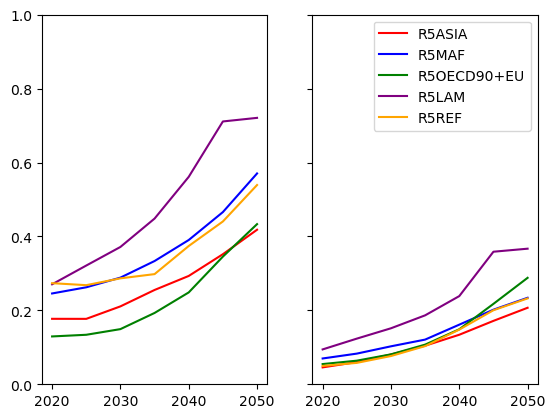

<IPython.core.display.Javascript object>

In [53]:
fig, ax = plt.subplots(1, 2, sharey=True)
for reg in region_color_maps.keys():
    med_ch4 = share_ch4.filter(region=reg, year=range(2020, 2055, 5)).timeseries().median()
    med_n2o = share_n2o.filter(region=reg, year=range(2020, 2055, 5)).timeseries().median()
    ax[0].plot(med_ch4.index, med_ch4.values, color=region_color_maps[reg], label=reg)
    ax[1].plot(med_n2o.index, med_n2o.values, color=region_color_maps[reg], label=reg)
ax[0].set_ylim(0, 1)
ax[1].legend()

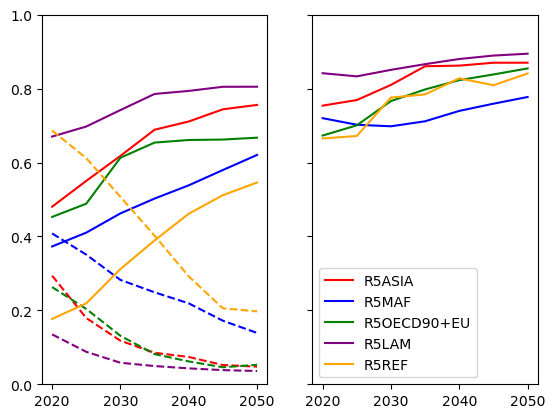

<IPython.core.display.Javascript object>

In [54]:
fig, ax = plt.subplots(1, 2, sharey=True)
for reg in region_color_maps.keys():
    med_ch4 = component_ch4_afolu.filter(region=reg, year=range(2020, 2055, 5)).timeseries().median()
    med_ch4_energy = component_ch4_energy.filter(region=reg, year=range(2020, 2055, 5)).timeseries().median()
    med_n2o = component_n2o_afolu.filter(region=reg, year=range(2020, 2055, 5)).timeseries().median()
    ax[0].plot(med_ch4.index, med_ch4.values, color=region_color_maps[reg], label=reg)
    ax[0].plot(med_ch4_energy.index, med_ch4_energy.values, color=region_color_maps[reg], linestyle='--')
    ax[1].plot(med_n2o.index, med_n2o.values, color=region_color_maps[reg], label=reg)
ax[0].set_ylim(0, 1)
ax[1].legend()

Supplementary figure 2.

Text(0, 0.5, 'Composition of N$_2$O emissions')

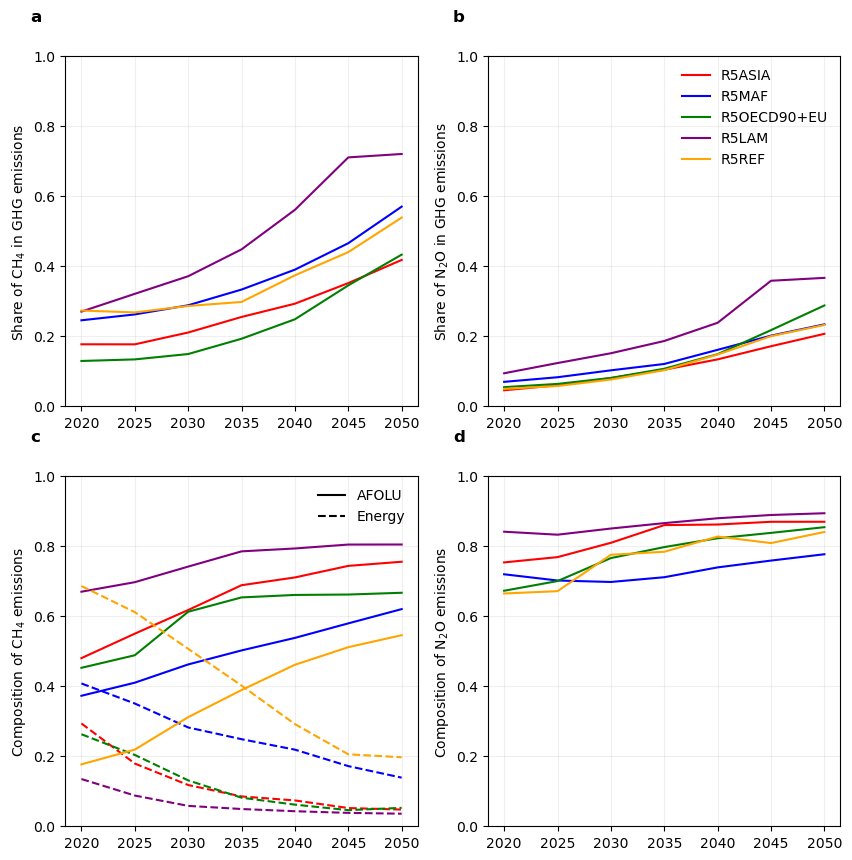

<IPython.core.display.Javascript object>

In [55]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)
# Start plotting the share of CH4 and N2O emissions
for reg in region_color_maps.keys():
    med_ch4 = share_ch4.filter(region=reg, year=range(2020, 2055, 5)).timeseries().median()
    med_n2o = share_n2o.filter(region=reg, year=range(2020, 2055, 5)).timeseries().median()
    ax[0, 0].plot(med_ch4.index, med_ch4.values, color=region_color_maps[reg], label=reg)
    ax[0, 1].plot(med_n2o.index, med_n2o.values, color=region_color_maps[reg], label=reg)
# Now plot the share of AFOLU and energy
for reg in region_color_maps.keys():
    med_ch4 = component_ch4_afolu.filter(region=reg, year=range(2020, 2055, 5)).timeseries().median()
    med_ch4_energy = component_ch4_energy.filter(region=reg, year=range(2020, 2055, 5)).timeseries().median()
    med_n2o = component_n2o_afolu.filter(region=reg, year=range(2020, 2055, 5)).timeseries().median()
    ax[1,0].plot(med_ch4.index, med_ch4.values, color=region_color_maps[reg], label=reg)
    ax[1,0].plot(med_ch4_energy.index, med_ch4_energy.values, color=region_color_maps[reg], linestyle='--')
    ax[1,1].plot(med_n2o.index, med_n2o.values, color=region_color_maps[reg], label=reg)
ax[0,1].legend(frameon=False)
add_legend = [
    Line2D([0], [0], color='black', label='AFOLU'),
    Line2D([0], [0], color='black', linestyle='--', label='Energy')
]
ax[1,0].legend(handles=add_legend, frameon=False)
for n,a in enumerate(ax[0]):
    a.grid(alpha=0.2)
    a.set_ylim(0, 1)
    a.xaxis.set_tick_params(labelbottom=True)
    a.yaxis.set_tick_params(labelleft=True)
    a.text(-0.1, 1.1, string.ascii_lowercase[n], transform=a.transAxes, 
            size=12, weight='bold')
for n, a in enumerate(ax[1]):
    a.grid(alpha=0.2)
    a.set_ylim(0, 1)
    a.xaxis.set_tick_params(labelbottom=True)
    a.yaxis.set_tick_params(labelleft=True)
    a.text(-0.1, 1.1, string.ascii_lowercase[n+2], transform=a.transAxes, 
            size=12, weight='bold')
ax[0,0].set_ylabel('Share of CH$_4$ in GHG emissions')
ax[0,1].set_ylabel('Share of N$_2$O in GHG emissions')
ax[1,0].set_ylabel('Composition of CH$_4$ emissions')
ax[1,1].set_ylabel('Composition of N$_2$O emissions')

In [56]:
fig.savefig(
    Path(
        'figures/SI_fig2.png'
    ),
    dpi=300,
    bbox_inches='tight'
)

<IPython.core.display.Javascript object>

Ok, getting back to the original assessment - now going back to net zero CO2 to 2100.

In [57]:
statement1_global.loc[
    pd.IndexSlice[:, :,: , 'netzero-2100'],
    :
]

count   mean    std     min  \
Category variable    region      timeframe                                   
C1       cdr         R5ASIA      netzero-2100   70.0 -169.0   87.0  -435.0   
                     R5LAM       netzero-2100   70.0 -125.0   56.0  -275.0   
                     R5MAF       netzero-2100   70.0 -106.0   46.0  -244.0   
                     R5OECD90+EU netzero-2100   70.0 -145.0   84.0  -330.0   
                     R5REF       netzero-2100   70.0  -41.0   25.0  -147.0   
                     World       netzero-2100   70.0 -585.0  231.0 -1030.0   
         total-gross R5ASIA      netzero-2100   68.0  270.0  100.0    70.0   
                     R5LAM       netzero-2100   68.0   75.0   25.0    18.0   
                     R5MAF       netzero-2100   68.0  163.0   62.0    55.0   
                     R5OECD90+EU netzero-2100   68.0  137.0   53.0    37.0   
                     R5REF       netzero-2100   68.0   37.0   15.0    11.0   
                     World       netzero-2100   70.0  713.0  237.0   210.0   
C2       cdr         R5ASIA      netzero-2100  102.0 -193.0   85.0  -514.0   
                     R5LAM       netzero-2100  102.0 -137.0   58.0  -291.0   
                     R5MAF       netzero-2100  102.0 -123.0   61.0  -337.0   
                     R5OECD90+EU netzero-2100  102.0 -160.0   73.0  -390.0   
                     R5REF       netzero-2100  102.0  -42.0   27.0  -158.0   
                     World       netzero-2100  102.0 -655.0  215.0 -1264.0   
         total-gross R5ASIA      netzero-2100   96.0  243.0   54.0   145.0   
                     R5LAM       netzero-2100   96.0   70.0   23.0    36.0   
                     R5MAF       netzero-2100   96.0  144.0   46.0    70.0   
                     R5OECD90+EU netzero-2100   96.0  124.0   45.0    64.0   
                     R5REF       netzero-2100   96.0   37.0   14.0    16.0   
                     World       netzero-2100  102.0  642.0  160.0   363.0   
C3       cdr         R5ASIA      netzero-2100  229.0 -108.0   67.0  -343.0   
                     R5LAM       netzero-2100  229.0  -71.0   42.0  -206.0   
                     R5MAF       netzero-2100  229.0  -57.0   43.0  -271.0   
                     R5OECD90+EU netzero-2100  229.0  -99.0   73.0  -338.0   
                     R5REF       netzero-2100  229.0  -28.0   18.0  -112.0   
                     World       netzero-2100  229.0 -364.0  196.0  -924.0   
         total-gross R5ASIA      netzero-2100  223.0  178.0   92.0     4.0   
                     R5LAM       netzero-2100  223.0   50.0   27.0     1.0   
                     R5MAF       netzero-2100  223.0  109.0   62.0     3.0   
                     R5OECD90+EU netzero-2100  223.0   95.0   55.0     2.0   
                     R5REF       netzero-2100  223.0   26.0   15.0     0.0   
                     World       netzero-2100  229.0  475.0  245.0    12.0   

                                                 25%    50%    75%     max  
Category variable    region      timeframe                                  
C1       cdr         R5ASIA      netzero-2100 -195.0 -142.0 -123.0   -26.0  
                     R5LAM       netzero-2100 -151.0 -121.0 -101.0   -16.0  
                     R5MAF       netzero-2100 -118.0 -101.0  -84.0    -7.0  
                     R5OECD90+EU netzero-2100 -199.0 -110.0  -86.0   -13.0  
                     R5REF       netzero-2100  -53.0  -32.0  -25.0    -6.0  
                     World       netzero-2100 -763.0 -532.0 -418.0   -68.0  
         total-gross R5ASIA      netzero-2100  203.0  255.0  328.0   666.0  
                     R5LAM       netzero-2100   59.0   71.0   86.0   181.0  
                     R5MAF       netzero-2100  121.0  160.0  190.0   419.0  
                     R5OECD90+EU netzero-2100  109.0  135.0  153.0   376.0  
                     R5REF       netzero-2100   27.0   40.0   45.0    83.0  
                     World       netzero-2100  559.0  695.0  831.0  1767.0  
C2  

<IPython.core.display.Javascript object>

In [60]:
land_share = panel_a_reshaped[
    (panel_a_reshaped['variable'].isin(['share-land-cdr']))
].groupby(['Category', 'variable', 'region', 'timeframe'])['Value'].describe().round(2)

<IPython.core.display.Javascript object>

In [62]:
land_share.loc[
    pd.IndexSlice[:,:,'R5LAM','netzero-2100']
]

,,count,mean,std,min,25%,50%,75%,max
Category,variable,,,,,,,,
C1,share-land-cdr,70.0,0.50,0.19,0.14,0.38,0.49,0.56,1.00
C2,share-land-cdr,102.0,0.38,0.18,0.02,0.29,0.41,0.49,0.98
C3,share-land-cdr,229.0,0.46,0.20,0.03,0.32,0.45,0.57,1.00


<IPython.core.display.Javascript object>